In [37]:
import torch
import clip
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import os
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000021BF0827CE0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [67]:
cifar100 = CIFAR100(root='./data', train=False, download=False, transform=preprocess)
dataloader = DataLoader(cifar100, batch_size=64, shuffle=False)

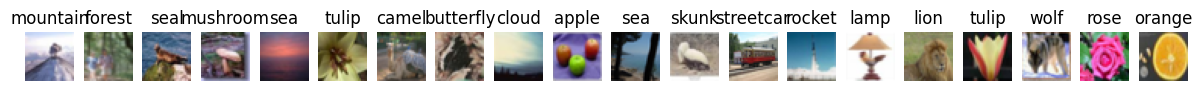

In [54]:
# Function to display a batch of images without any transformations
def show_original_images(dataset, num_images=20):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(cifar100.classes[label])
    plt.show()

# Display the first few images in their original form
show_original_images(cifar100)

In [12]:
# encoding CIFAR-100 images
image_features_list = []
with torch.no_grad():
    for images, _ in dataloader:
        images = images.to(device)
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_features_list.append(image_features.cpu())

image_features = torch.cat(image_features_list)

In [64]:
image_features

tensor([[-0.0057,  0.0053, -0.0171,  ...,  0.0596,  0.0235,  0.0092],
        [-0.0225, -0.0025, -0.0256,  ...,  0.0775, -0.0257,  0.0046],
        [ 0.0526,  0.0270, -0.0288,  ...,  0.0643,  0.0052, -0.0064],
        ...,
        [-0.0024,  0.0174, -0.0052,  ...,  0.0812,  0.0011, -0.0207],
        [ 0.0186, -0.0067, -0.0398,  ...,  0.0791, -0.0062, -0.0055],
        [ 0.0109,  0.0170, -0.0306,  ...,  0.0726, -0.0022, -0.0190]])

In [14]:
torch.save(image_features, 'cifar100_image_features.pt')

In [15]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions)

In [16]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [17]:
torch.save(text_features, 'cifar100_text_features.pt')

In [18]:
text_features = torch.load('cifar100_text_features.pt')

In [26]:
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
similarity

array([[0.19005305, 0.21254754, 0.20466265, ..., 0.2184984 , 0.22057182,
        0.2485758 ],
       [0.20673606, 0.22770861, 0.250623  , ..., 0.21296635, 0.25571814,
        0.25164926],
       [0.20677371, 0.22981447, 0.21510279, ..., 0.20996104, 0.23049068,
        0.24642503],
       ...,
       [0.19301069, 0.21523671, 0.22340544, ..., 0.19859536, 0.23502108,
        0.21812773],
       [0.20051028, 0.2282469 , 0.20834494, ..., 0.20124783, 0.22630462,
        0.23136748],
       [0.19064943, 0.20348835, 0.2088758 , ..., 0.21798293, 0.22055526,
        0.22645761]], dtype=float32)

In [83]:
def find_relevant_images(prompt, model, image_features, text_features, device):
    # Tokenize the prompt
    text_inputs = clip.tokenize([prompt]).to(device)
    
    # Compute the features of the text prompt
    with torch.no_grad():
        prompt_features = model.encode_text(text_inputs).float()
        prompt_features /= prompt_features.norm(dim=-1, keepdim=True)
    
    # Compute the similarity between the prompt and the text features
    text_similarities = torch.nn.functional.cosine_similarity(prompt_features, text_features, dim=-1)
    
    # Find the most similar class indices
    top_text_indices = text_similarities.topk(20, largest=True).indices
    
    # Compute the similarity between image features and the most similar text features
    # image_similarities = (100 * prompt_features @ image_features.T).softmax(dim = -1)
    image_similarities = text_features[top_text_indices] @ image_features.T
    # image_similarities = prompt_features @ image_features.T
    # Get the indices of the most similar images
    top_image_indices = image_similarities.topk(5, largest=True).indices
    
    return top_image_indices

# Function to show images
def show_images(indices, dataset):
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


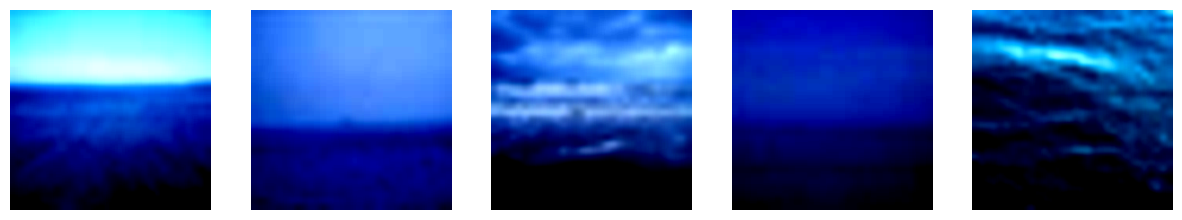

In [90]:

# Example usage
prompt = "sea"
relevant_indices = find_relevant_images(prompt, model, image_features, text_features, device)


# Display the images
show_images(relevant_indices[0], cifar100)  